In [1]:
import geopandas as gpd
import pandas as pd

from shapely.ops import unary_union, linemerge
from shapely.geometry import Point, LineString, MultiLineString
from shapely.geometry import mapping

import folium
from folium import Map, GeoJson

import json



### Berlin einlesen für Proof of concept

In [38]:
net = gpd.read_file("../data/way_import.geojson")
len(net)

7105

In [39]:
wanted_highways = [
    "residential",
    "service",
    "secondary",
    "tertiary",
    "primary",
    "track",
    "unclassified",
    "secondary_link",
    "tertiary_link",
    "primary_link"
]
net_filtered = net[net["highway"].isin(wanted_highways)].copy()
len(net_filtered)

5466

In [40]:
# get schillerkiez

import requests
import geopandas as gpd
from shapely.geometry import shape
import osm2geojson
from shapely.ops import unary_union, polygonize


# Deine Overpass-Query
query = """
[out:json][timeout:90];
area["name"="Berlin"]["boundary"="administrative"]->.berlin;

(
  rel(area.berlin)["name"="Schillerkiez"];
);

out body;
>;
out skel qt;
"""

# Anfrage an Overpass API
url = "https://overpass-api.de/api/interpreter"
response = requests.post(url, data={'data': query})
data = response.json()

# JSON -> GeoJSON
res_geojson = osm2geojson.json2geojson(data)

# GeoJSON -> GeoDataFrame
gdf = gpd.GeoDataFrame.from_features(res_geojson["features"], crs="EPSG:4326")

gdf_schiller = gdf[gdf["type"]=="relation"]

# Alle Linien zu einer Geometrie vereinigen
merged_lines = unary_union(gdf_schiller.geometry)

# Versuche, daraus gültige Polygone zu bilden
polygons = list(polygonize(merged_lines))

# Nimm den größten (falls mehrere)
poly = max(polygons, key=lambda p: p.area)

gdf_schiller_poly = gpd.GeoDataFrame({"name": ["Schillerkiez"], "geometry": [poly]}, crs=gdf_schiller.crs)



<Axes: >

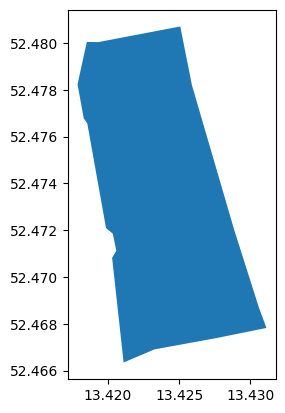

In [41]:
gdf_schiller_poly.plot()

<Axes: >

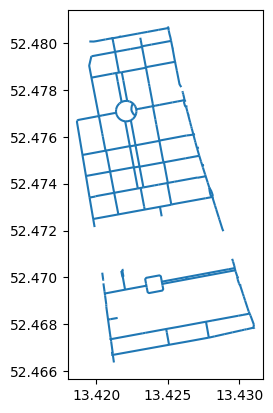

In [42]:
net_schiller = net_filtered.clip(gdf_schiller_poly)

net_schiller.plot()


In [43]:
"""
Compute effective carriageway width from OSM tags in a GeoDataFrame.

This module derives an "effective" road width that remains for motor traffic
(after subtracting on-carriageway parking lanes and on-carriageway cycle lanes)
using commonly mapped OSM tags. It is written to be robust against missing tags
and uses reasonable, documented defaults.

Expected columns (any subset; more is better):
  - width:carriageway, width, est_width
  - lanes, lanes:forward, lanes:backward
  - highway
  - parking:left, parking:right, parking:both
  - parking:left:orientation, parking:right:orientation
  - parking:left:position,    parking:right:position
  - parking:left:width,       parking:right:width
  - cycleway, cycleway:left, cycleway:right, cycleway:both
  - cycleway:width, cycleway:left:width, cycleway:right:width
  - oneway (optional; not required here)

Result columns added:
  - width_base               (float, meters)
  - parking_left_onlane_m    (float, meters)
  - parking_right_onlane_m   (float, meters)
  - cycleway_left_onlane_m   (float, meters)
  - cycleway_right_onlane_m  (float, meters)
  - width_effective          (float, meters, >= 0.0)

Usage:
    import geopandas as gpd
    from effective_width_geopandas import derive_effective_width

    gdf = gpd.read_file("edges.gpkg")
    gdf = derive_effective_width(gdf)
    # gdf["width_effective"] now contains the result in meters
"""
from __future__ import annotations

from typing import Dict, Iterable, Optional
import numpy as np
import pandas as pd

# ----------------------------- Defaults ------------------------------------ #

# Default values for width quality evaluations on shared roads
# Based on OSM Cycling Quality Index: https://github.com/SupaplexOSM/OSM-Cycling-Quality-Index
DEFAULT_WIDTH_TRAFFIC_LANE = 3.2        # average width of a driving lane (for common motor cars)
DEFAULT_WIDTH_BUS_LANE = 4.5            # average width of a bus/psv lane
DEFAULT_WIDTH_CYCLE_LANE = 1.4          # average width of a cycle lane
DEFAULT_WIDTH_PARKING_PARALLEL = 2.2    # average width of parallel parking
DEFAULT_WIDTH_PARKING_DIAGONAL = 4.5    # average width of diagonal parking
DEFAULT_WIDTH_PARKING_PERPENDICULAR = 5.0 # average width of perpendicular parking

# Default lane widths (meters) by highway class when we must estimate from lanes
# Using traffic lane width as base default
LANE_WIDTH_BY_HIGHWAY: Dict[str, float] = {
    # high-capacity roads
    "motorway": 3.75,
    "motorway_link": 3.75,
    "trunk": 3.75,
    "trunk_link": 3.75,
    # arterials
    "primary": 3.50,
    "primary_link": 3.50,
    "secondary": 3.50,
    "secondary_link": 3.50,
    # collectors / locals
    "tertiary": 3.25,
    "tertiary_link": 3.25,
    "unclassified": 3.25,
    "residential": 3.25,
    # narrow contexts
    "living_street": 3.00,
    "service": 3.00,
}
DEFAULT_LANE_WIDTH = DEFAULT_WIDTH_TRAFFIC_LANE  # Use standard traffic lane width

# Parking orientation -> typical width (meters)
# Based on OSM Cycling Quality Index defaults
PARKING_WIDTH_BY_ORIENTATION: Dict[str, float] = {
    "parallel": DEFAULT_WIDTH_PARKING_PARALLEL,
    "diagonal": DEFAULT_WIDTH_PARKING_DIAGONAL,
    "perpendicular": DEFAULT_WIDTH_PARKING_PERPENDICULAR,
}
DEFAULT_PARALLEL_PARKING_WIDTH = DEFAULT_WIDTH_PARKING_PARALLEL

# Fraction of the parking width that actually occupies the carriageway
# depending on the mapped "position" (street-parking schema).
PARKING_CARRIAGEWAY_FRACTION: Dict[str, float] = {
    "lane": 1.0,           # on carriageway
    "shoulder": 1.0,      # treat as occupying carriageway width
    "half_on_kerb": 0.5,  # half occupies carriageway
    "on_kerb": 0.0,       # fully on kerb/sidewalk → no subtraction
    "street_side": 0.0,   # bays next to carriageway → no subtraction
    "separate": 0.0,
    "no": 0.0,
}
DEFAULT_PARKING_POSITION = "lane"

# Default cycle lane width (meters) if a width tag is missing
# Based on OSM Cycling Quality Index default
DEFAULT_CYCLE_LANE_WIDTH = DEFAULT_WIDTH_CYCLE_LANE


# ----------------------------- Helpers ------------------------------------- #

def _coerce_float(series: Optional[pd.Series], index: Optional[pd.Index] = None) -> pd.Series:
    """Try to convert strings like '3.5', '3,5', '3.5 m' to float meters."""
    if series is None:
        # Return Series with proper index if provided, otherwise empty
        if index is not None:
            return pd.Series(index=index, dtype=float)
        return pd.Series(dtype=float)
    s = series.astype(str).str.strip()
    # Replace comma decimals, strip units
    s = (
        s.str.replace(",", ".", regex=False)
         .str.replace(" metres", "", regex=False)
         .str.replace(" meter", "", regex=False)
         .str.replace(" meters", "", regex=False)
         .str.replace(" m", "", regex=False)
    )
    out = pd.to_numeric(s, errors="coerce")
    return out


def _first_nonnull(*cols: Iterable[pd.Series]) -> pd.Series:
    """Return the first non-null among given series (aligned index)."""
    if not cols:
        raise ValueError("No columns provided")
    result = cols[0].copy()
    for s in cols[1:]:
        result = result.where(result.notna(), s)
    return result


def _lane_width_from_highway(hw: pd.Series) -> pd.Series:
    return hw.map(LANE_WIDTH_BY_HIGHWAY).fillna(DEFAULT_LANE_WIDTH)


def _sum_lanes(df: pd.DataFrame) -> pd.Series:
    """Get total lanes using lanes or lanes:forward + lanes:backward."""
    lanes_total = pd.to_numeric(df.get("lanes"), errors="coerce")
    lf = pd.to_numeric(df.get("lanes:forward"), errors="coerce")
    lb = pd.to_numeric(df.get("lanes:backward"), errors="coerce")
    lanes_fb = (lf.fillna(0) + lb.fillna(0))
    return lanes_total.fillna(lanes_fb).replace(0, np.nan)


def _parking_width_side(
    df: pd.DataFrame,
    side: str,
) -> pd.Series:
    """Compute parking width to subtract for one side (left/right).

    Subtract only the portion that lies on the carriageway (fraction by position).
    Priority of width sources:
        parking:<side>:width → else orientation default → default parallel width.
    Position default is assumed to be 'lane' when unknown.
    
    For highway=path, no default parking is assumed if no parking tags are present.
    """
    assert side in ("left", "right")

    # Get side-specific and both tags, handling missing columns
    p_base = df.get(f"parking:{side}")
    p_both = df.get("parking:both")
    
    # Handle case where column doesn't exist (returns None)
    if p_base is None:
        p_base = pd.Series(index=df.index, dtype=object)
    if p_both is None:
        p_both = pd.Series(index=df.index, dtype=object)
    
    # Combine side-specific and both tags
    base_val = p_base.where(p_base.notna(), p_both)

    # orientation and position
    orient = df.get(f"parking:{side}:orientation")
    if orient is None:
        orient = pd.Series(index=df.index, dtype=object)
    
    pos = df.get(f"parking:{side}:position")
    if pos is None:
        pos = pd.Series(index=df.index, dtype=object)

    # width as mapped (meters)
    width_tag = _coerce_float(df.get(f"parking:{side}:width"), index=df.index)

    # Check if highway=path and no parking tags are present
    highway = df.get("highway", pd.Series(index=df.index, dtype=object))
    has_parking_tags = base_val.notna() | width_tag.notna() | orient.notna() | pos.notna()
    is_path = highway == "path"
    
    # For highway=path, if no parking tags are present, return 0.0
    no_default_for_path = is_path & ~has_parking_tags

    # derive raw width by orientation default when width is missing
    orient_width = orient.map(PARKING_WIDTH_BY_ORIENTATION) if orient is not None else None
    if orient_width is None:
        orient_width = pd.Series(index=df.index, dtype=float)
    orient_width = orient_width.fillna(DEFAULT_PARALLEL_PARKING_WIDTH)

    raw_width = width_tag.where(width_tag.notna(), orient_width)
    
    # Set to 0.0 for path without parking tags
    raw_width = raw_width.where(~no_default_for_path, 0.0)

    # carriageway fraction from position / base tag
    frac_from_pos = pos.map(PARKING_CARRIAGEWAY_FRACTION) if pos is not None else None
    if frac_from_pos is None:
        frac_from_pos = pd.Series(index=df.index, dtype=float)

    # If explicit position is missing, infer from base tag value
    # Treat 'lane' as on-carriageway; 'street_side'/'separate' as off-carriageway
    inferred_frac = pd.Series(0.0, index=df.index)
    if base_val is not None and base_val.notna().any():
        inferred_frac = (
            base_val.replace({
                "lane": 1.0,
                "shoulder": 1.0,
                "half_on_kerb": 0.5,
                "on_kerb": 0.0,
                "street_side": 0.0,
                "separate": 0.0,
                "no": 0.0,
            }).infer_objects(copy=False)
        )
        # Any unknown strings become NaN → fill later
        inferred_frac = pd.to_numeric(inferred_frac, errors="coerce")

    frac = frac_from_pos.where(frac_from_pos.notna(), inferred_frac)
    # For path without parking tags, don't use default position
    default_frac = pd.Series(PARKING_CARRIAGEWAY_FRACTION.get(DEFAULT_PARKING_POSITION, 1.0), index=df.index)
    default_frac = default_frac.where(~no_default_for_path, 0.0)
    frac = frac.where(frac.notna(), default_frac)

    return (raw_width * frac).fillna(0.0)


def _cycle_lane_width_side(df: pd.DataFrame, side: str) -> pd.Series:
    """Cycle LANE width to subtract for one side (left/right).

    We subtract only when the mapping indicates an on-carriageway lane.
    Keys considered as on-carriageway: 'lane', 'share_busway'.
    'track' is off-carriageway and does not reduce carriageway width.
    """
    assert side in ("left", "right")

    # Side-specific value has priority over generic
    side_val = df.get(f"cycleway:{side}")
    both_val = df.get("cycleway:both")
    generic = df.get("cycleway")

    # Determine effective type for this side
    eff = side_val.copy() if side_val is not None else pd.Series(index=df.index, dtype=object)
    if both_val is not None:
        eff = eff.where(eff.notna(), both_val)
    if generic is not None:
        eff = eff.where(eff.notna(), generic)

    eff = eff.fillna("")

    # Width sources
    width_side = _coerce_float(df.get(f"cycleway:{side}:width"), index=df.index)
    width_both = _coerce_float(df.get("cycleway:width"), index=df.index)

    width_raw = width_side.where(width_side.notna(), width_both)
    width_raw = width_raw.fillna(DEFAULT_CYCLE_LANE_WIDTH)

    # Only subtract for on-carriageway types
    onlane_mask = eff.isin(["lane", "share_busway", "advisory"])
    # advisory bike lanes still occupy some width; we treat them like lanes

    return width_raw.where(onlane_mask, 0.0)


# --------------------------- Public API ------------------------------------ #

def derive_effective_width(
    gdf: "pd.DataFrame",
    *,
    lane_width_by_highway: Optional[Dict[str, float]] = None,
    default_lane_width: float = DEFAULT_LANE_WIDTH,
    parking_width_by_orientation: Optional[Dict[str, float]] = None,
    default_parallel_parking_width: float = DEFAULT_PARALLEL_PARKING_WIDTH,
    parking_carriageway_fraction: Optional[Dict[str, float]] = None,
    default_parking_position: str = DEFAULT_PARKING_POSITION,
    default_cycle_lane_width: float = DEFAULT_CYCLE_LANE_WIDTH,
    clamp_nonnegative: bool = True,
) -> "pd.DataFrame":
    """Add effective width columns to a (Geo)DataFrame of OSM ways.

    Parameters
    ----------
    gdf : DataFrame or GeoDataFrame with OSM-like tags as columns.
    lane_width_by_highway : dict, optional override of highway→lane width.
    default_lane_width : float, fallback lane width when highway unknown.
    parking_width_by_orientation : dict, override orientation defaults.
    default_parallel_parking_width : float, fallback when orientation unknown.
    parking_carriageway_fraction : dict, override position→fraction mapping.
    default_parking_position : str, assumed position when nothing is mapped.
    default_cycle_lane_width : float, used if cycle lane width missing.
    clamp_nonnegative : bool, clip width_effective to >= 0.

    Returns
    -------
    DataFrame with added columns; input object is returned for chaining.
    """
    df = gdf.copy()

    # Allow overrides
    global LANE_WIDTH_BY_HIGHWAY, DEFAULT_LANE_WIDTH
    global PARKING_WIDTH_BY_ORIENTATION, DEFAULT_PARALLEL_PARKING_WIDTH
    global PARKING_CARRIAGEWAY_FRACTION, DEFAULT_PARKING_POSITION
    global DEFAULT_CYCLE_LANE_WIDTH

    if lane_width_by_highway is not None:
        LANE_WIDTH_BY_HIGHWAY = lane_width_by_highway
    DEFAULT_LANE_WIDTH = default_lane_width

    if parking_width_by_orientation is not None:
        PARKING_WIDTH_BY_ORIENTATION = parking_width_by_orientation
    DEFAULT_PARALLEL_PARKING_WIDTH = default_parallel_parking_width

    if parking_carriageway_fraction is not None:
        PARKING_CARRIAGEWAY_FRACTION = parking_carriageway_fraction
    DEFAULT_PARKING_POSITION = default_parking_position

    DEFAULT_CYCLE_LANE_WIDTH = default_cycle_lane_width

    # 1) Base width from explicit width tags
    width_carriageway = _coerce_float(df.get("width:carriageway"), index=df.index)
    width_total = _coerce_float(df.get("width"), index=df.index)
    width_est = _coerce_float(df.get("est_width"), index=df.index)

    # 2) Fallback: estimate from lanes
    lanes_total = _sum_lanes(df)
    lane_w = _lane_width_from_highway(df.get("highway", pd.Series(index=df.index)))
    width_from_lanes = lanes_total * lane_w

    # First non-null among carriageway width, total width, est_width, lanes-based
    width_base = _first_nonnull(width_carriageway, width_total, width_est, width_from_lanes)

    df["width_base"] = width_base

    # 3) Parking subtraction (on-carriageway only)
    df["parking_left_onlane_m"] = _parking_width_side(df, "left")
    df["parking_right_onlane_m"] = _parking_width_side(df, "right")

    # 4) Cycle lane subtraction (on-carriageway only)
    df["cycleway_left_onlane_m"] = _cycle_lane_width_side(df, "left")
    df["cycleway_right_onlane_m"] = _cycle_lane_width_side(df, "right")

    # 5) Effective width
    subtract_sum = (
        df[[
            "parking_left_onlane_m",
            "parking_right_onlane_m",
            "cycleway_left_onlane_m",
            "cycleway_right_onlane_m",
        ]]
        .sum(axis=1, min_count=1)
        .fillna(0.0)
    )

    df["width_effective"] = df["width_base"] - subtract_sum

    if clamp_nonnegative:
        df["width_effective"] = df["width_effective"].clip(lower=0.0)

    return df


# ------------------------------ Demo --------------------------------------- #
if __name__ == "__main__":
    # Minimal smoke test with pandas only (no geometry required)
    # demo = pd.DataFrame(
    #     [
    #         {"highway": "residential", "lanes": 2, "parking:left": "lane", "parking:left:orientation": "parallel"},
    #         {"width:carriageway": "7.0", "parking:right": "street_side"},
    #         {"width": "6,5 m", "cycleway:right": "lane", "cycleway:right:width": "1.8"},
    #         {"lanes:forward": 2, "lanes:backward": 1, "highway": "primary", "parking:left": "lane", "parking:left:orientation": "diagonal"},
    #     ]
    # )
    demo = derive_effective_width(net_schiller)
    with pd.option_context("display.max_columns", None):
        print(demo)


                  id             @id abandoned:aeroway access  \
864     way/31046853    way/31046853              None   None   
1782   way/155594998   way/155594998              None   None   
1771   way/155594969   way/155594969              None   None   
5285  way/1006839433  way/1006839433              None   None   
6532  way/1186591354  way/1186591354              None   None   
...              ...             ...               ...    ...   
1308    way/68189545    way/68189545              None   None   
2432   way/329019784   way/329019784              None   None   
6689  way/1217061913  way/1217061913              None   None   
2431   way/328934524   way/328934524              None   None   
785     way/28496020    way/28496020              None   None   

     access:double_decker_bus access:lanes alt_name architect  area  \
864                      None         None     None      None  None   
1782                     None         None     None      None  None   
1771  

/tmp/ipykernel_12796/3462985837.py:219: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_val.replace({
/tmp/ipykernel_12796/3462985837.py:219: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_val.replace({


In [28]:
demo.columns

Index(['id', '@id', 'abandoned:aeroway', 'access', 'access:double_decker_bus',
       'access:lanes', 'alt_name', 'architect', 'area', 'bicycle',
       ...
       'winter_service', 'zone:maxspeed', 'zone:traffic', 'geometry',
       'width_base', 'parking_left_onlane_m', 'parking_right_onlane_m',
       'cycleway_left_onlane_m', 'cycleway_right_onlane_m', 'width_effective'],
      dtype='object', length=501)

In [44]:
demo.highway.value_counts()

highway
residential       148
secondary          62
service            13
tertiary            2
secondary_link      1
Name: count, dtype: int64

In [45]:
# Finde die 10 häufigsten Tags (basierend auf nicht-NaN-Werten)
# Exkludiere geometry und width_effective
exclude_cols = {'geometry', 'width_base', 'parking_left_onlane_m', 'parking_right_onlane_m',
       'cycleway_left_onlane_m', 'cycleway_right_onlane_m', 'width_effective'}
all_cols = [col for col in demo.columns if col not in exclude_cols]

# Zähle nicht-NaN-Werte pro Spalte
non_null_counts = {col: demo[col].notna().sum() for col in all_cols}

# Sortiere nach Häufigkeit und nimm die Top 10
top_6_tags = sorted(non_null_counts.items(), key=lambda x: x[1], reverse=True)[:6]
top_6_cols = [col for col, count in top_6_tags]

# Füge width_effective hinzu (falls es nicht schon dabei ist)
tooltip_cols = top_6_cols + ['width_base', 'parking_left_onlane_m', 'parking_right_onlane_m',
       'cycleway_left_onlane_m', 'cycleway_right_onlane_m', 'width_effective']
# Entferne Duplikate, falls width_effective schon in top_16_cols war
tooltip_cols = list(dict.fromkeys(tooltip_cols))

print(f"Tooltip Spalten ({len(tooltip_cols)}): {tooltip_cols}")
demo.explore(column="width_effective", tooltip=tooltip_cols, tiles="CartoDB positron")

Tooltip Spalten (12): ['id', '@id', 'highway', 'surface', 'lit', 'width', 'width_base', 'parking_left_onlane_m', 'parking_right_onlane_m', 'cycleway_left_onlane_m', 'cycleway_right_onlane_m', 'width_effective']


way/25680611

In [26]:
# Zeige nur Spalten, die nicht None/NaN sind
row = net[net.id=="way/25680611"]
if len(row) > 0:
    # Filtere Spalten, die nicht None/NaN sind (für diese Zeile)
    non_none_cols = [col for col in row.columns if pd.notna(row[col].iloc[0])]
    row[non_none_cols]
else:
    print("Keine Zeile gefunden")

In [27]:
net[net.id=="way/25680611"].columns

Index(['id', '@id', 'abandoned:aeroway', 'access', 'access:double_decker_bus',
       'access:lanes', 'alt_name', 'architect', 'area', 'bicycle',
       ...
       'width:lanes:forward:start', 'width:lanes:start', 'width:start',
       'wikidata', 'wikimedia_commons', 'wikipedia', 'winter_service',
       'zone:maxspeed', 'zone:traffic', 'geometry'],
      dtype='object', length=495)

In [50]:
import pandas as pd

# Liste der gewünschten Spalten
wanted_cols = [ "id", "geometry",
    "width:carriageway", "width", "est_width",
    "lanes", "lanes:forward", "lanes:backward",
    "highway",
    "parking:left", "parking:right", "parking:both",
    "parking:left:orientation", "parking:right:orientation",
    "parking:left:position", "parking:right:position",
    "parking:left:width", "parking:right:width",
    "cycleway", "cycleway:left", "cycleway:right", "cycleway:both",
    "cycleway:width", "cycleway:left:width", "cycleway:right:width",
    "oneway",
    # optional: die berechneten Ergebnis-Spalten
    "width_base", "parking_left_onlane_m", "parking_right_onlane_m",
    "cycleway_left_onlane_m", "cycleway_right_onlane_m",
    "width_effective"
]
# Wenn df ein GeoDataFrame ist:
available = [c for c in wanted_cols if c in demo.columns]
demo_filtered = demo[available].copy()

In [51]:
demo_filtered

id                                           geometry  \
864     way/31046853  LINESTRING (13.42787 52.46744, 13.428 52.46745...   
1782   way/155594998  LINESTRING (13.42116 52.4667, 13.42124 52.4667...   
1771   way/155594969  LINESTRING (13.42493 52.46766, 13.42506 52.467...   
5285  way/1006839433  LINESTRING (13.42325 52.46762, 13.42342 52.46764)   
6532  way/1186591354  LINESTRING (13.42489 52.4678, 13.42491 52.4677...   
...              ...                                                ...   
1308    way/68189545  LINESTRING (13.42291 52.48039, 13.42304 52.480...   
2432   way/329019784   LINESTRING (13.42313 52.48042, 13.4236 52.48047)   
6689  way/1217061913   LINESTRING (13.4236 52.48047, 13.42433 52.48055)   
2431   way/328934524  LINESTRING (13.42433 52.48055, 13.42483 52.480...   
785     way/28496020   LINESTRING (13.42501 52.4807, 13.42503 52.48063)   

     width:carriageway width est_width lanes lanes:forward lanes:backward  \
864               None   8.5      None  None          None           None   
1782              None   8.5      None  None          None           None   
1771              None     9      None  None          None           None   
5285              None    11      None  None          None           None   
6532              None     9      None  None          None           None   
...                ...   ...       ...   ...           ...            ...   
1308              None    10      None     3          None           None   
2432              None    10      None     3          None           None   
6689              None    10      None     3          None           None   
2431              None    10      None     3          None           None   
785               None     8      None  None          None           None   

          highway parking:left  ... cycleway:width cycleway:left:width  \
864   residential         lane  ...           None                None   
1782  residential         None  ...           None                None   
1771  residential         None  ...           None                None   
5285  residential         None  ...           None                None   
6532  residential         None  ...           None                None   
...           ...          ...  ...            ...                 ...   
1308    secondary         None  ...           None                None   
2432    secondary         None  ...           None                None   
6689    secondary         None  ...           None                None   
2431    secondary         None  ...           None                None   
785     secondary         None  ...           None                None   

     cycleway:right:width oneway width_base parking_left_onlane_m  \
864                  None   None        8.5                   2.2   
1782                 None   None        8.5                   2.2   
1771                 None   None        9.0                   2.2   
5285                 None   None       11.0                   2.2   
6532                 None   None        9.0                   2.2   
...                   ...    ...        ...                   ...   
1308                 None    yes       10.0                   0.0   
2432                 None    yes       10.0                   0.0   
6689                 None    yes       10.0                   0.0   
2431                 None    yes       10.0                   0.0   
785                   1.2    yes        8.0                   0.0   

     parking_right_onlane_m cycleway_left_onlane_m cycleway_right_onlane_m  \
864                     0.0                    0.0                     0.0   
1782                    2.2                    0.0                     0.0   
1771                    2.2                    0.0                     0.0   
5285                    2.2                    0.0                     0.0   
6532                    2.2                    0.0                     0.0   
...   

In [52]:

demo_filtered.to_file("../data/demo_nettobreite.fgb", driver="FlatGeobuf")

In [53]:
def fgb_to_pmtiles_dual_layer( polys_fgb, output_pmtiles, layer_name):
    import subprocess
    from pathlib import Path


    subprocess.run([
        "tippecanoe", "-o", str(Path(output_pmtiles).resolve()),
        f"--layer={layer_name}-lines",
        "--minimum-zoom=9", "--maximum-zoom=11",
        "--force",
        #"--simplify-only-low-zooms",
        #"--no-simplification-of-shared-nodes", "--simplification=200",
        "--no-feature-limit",  #"--maximum-tile-bytes=4000000", #"--force-feature-limit", "--no-tile-size-limit", 
        str(Path(polys_fgb).resolve())
    ], check=True)



    print("✅ Combined PMTiles created")


In [54]:
fgb_to_pmtiles_dual_layer(
    #points_fgb="scenario8_laerm_schulen_points.fgb",
    polys_fgb="../data/demo_nettobreite.fgb",
    output_pmtiles="../data/demo_nettobreite.pmtiles",
    layer_name="nettobreite"
    )

✅ Combined PMTiles created


detected indexed FlatGeobuf: assigning feature IDs by sequence
226 features, 16015 bytes of geometry and attributes, 7803 bytes of string pool, 0 bytes of vertices, 0 bytes of nodes
  99.9%  11/1100/672  
